<a href="https://colab.research.google.com/github/Saibhossain/face-generation-model/blob/main/gan_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DCGAN

 Paper  [link text](https://arxiv.org/abs/1511.06434)

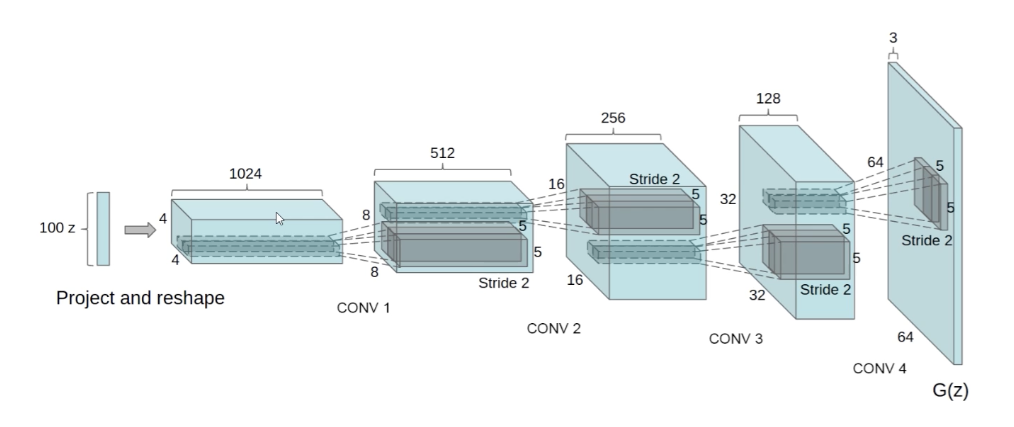

In [1]:
import torch
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # input: N x channels_img x 64 x 64
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            # After all _block img output is 4x4 (Conv2d below makes into 1x1)
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            # nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)

class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            self._block(channels_noise, features_g * 16, 4, 1, 0),  # img: 4x4
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            # Output: N x channels_img x 64 x 64
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            # nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)


def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)


def test():
    N, in_channels, H, W = 8, 3, 64, 64
    noise_dim = 100
    x = torch.randn((N, in_channels, H, W))
    disc = Discriminator(in_channels, 8)
    assert disc(x).shape == (N, 1, 1, 1), "Discriminator test failed"
    gen = Generator(noise_dim, in_channels, 8)
    z = torch.randn((N, noise_dim, 1, 1))
    assert gen(z).shape == (N, in_channels, H, W), "Generator test failed"
    print("Success, tests passed!")

if __name__ == "__main__":
    test()

Success, tests passed!


In [2]:
"""
Training of DCGAN network on MNIST dataset with Discriminator
and Generator imported from models.py

Programmed by Aladdin Persson <aladdin.persson at hotmail dot com>
* 2020-11-01: Initial coding
* 2022-12-20: Small revision of code, checked that it works with latest PyTorch version
"""

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter


# Hyperparameters etc.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 2e-4  # could also use two lrs, one for gen and one for disc
BATCH_SIZE = 128
IMAGE_SIZE = 64
CHANNELS_IMG = 1
NOISE_DIM = 100
NUM_EPOCHS = 5
FEATURES_DISC = 64
FEATURES_GEN = 64

transforms = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
        ),
    ]
)

# If you train on MNIST, remember to set channels_img to 1
dataset = datasets.MNIST(
    root="dataset/", train=True, transform=transforms, download=True
)

# comment mnist above and uncomment below if train on CelebA
# dataset = datasets.ImageFolder(root="celeb_dataset", transform=transforms)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
gen = Generator(NOISE_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)
initialize_weights(gen)
initialize_weights(disc)

opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
criterion = nn.BCELoss()

fixed_noise = torch.randn(32, NOISE_DIM, 1, 1).to(device)
writer_real = SummaryWriter(f"logs/real")
writer_fake = SummaryWriter(f"logs/fake")
step = 0

gen.train()
disc.train()

for epoch in range(NUM_EPOCHS):
    # Target labels not needed! <3 unsupervised
    for batch_idx, (real, _) in enumerate(dataloader):
        real = real.to(device)
        noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)
        fake = gen(noise)

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        disc_real = disc(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake.detach()).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        disc.zero_grad()
        loss_disc.backward()
        opt_disc.step()

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # Print losses occasionally and print to tensorboard
        if batch_idx % 100 == 0:
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(dataloader)} \
                  Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}"
            )

            with torch.no_grad():
                fake = gen(fixed_noise)
                # take out (up to) 32 examples
                img_grid_real = torchvision.utils.make_grid(real[:32], normalize=True)
                img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)

                writer_real.add_image("Real", img_grid_real, global_step=step)
                writer_fake.add_image("Fake", img_grid_fake, global_step=step)

            step += 1

100%|██████████| 9.91M/9.91M [00:00<00:00, 19.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 458kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.4MB/s]


Epoch [0/5] Batch 0/469                   Loss D: 0.6954, loss G: 0.6939
Epoch [0/5] Batch 100/469                   Loss D: 0.0002, loss G: 8.4983
Epoch [0/5] Batch 200/469                   Loss D: 0.0000, loss G: 9.7298
Epoch [0/5] Batch 300/469                   Loss D: 0.0000, loss G: 10.6090
Epoch [0/5] Batch 400/469                   Loss D: 0.0000, loss G: 11.2450
Epoch [1/5] Batch 0/469                   Loss D: 0.0000, loss G: 11.5741
Epoch [1/5] Batch 100/469                   Loss D: 0.0000, loss G: 11.6985
Epoch [1/5] Batch 200/469                   Loss D: 0.0000, loss G: 11.9401
Epoch [1/5] Batch 300/469                   Loss D: 0.0000, loss G: 12.5534
Epoch [1/5] Batch 400/469                   Loss D: 0.0000, loss G: 11.3931
Epoch [2/5] Batch 0/469                   Loss D: 0.0000, loss G: 12.7844
Epoch [2/5] Batch 100/469                   Loss D: 0.0000, loss G: 12.7226
Epoch [2/5] Batch 200/469                   Loss D: 0.0000, loss G: 13.1833
Epoch [2/5] Batch 300

In [6]:
torch.save(gen.state_dict(), "generator.pth")
torch.save(disc.state_dict(), "discriminator.pth")


In [7]:
gen = Generator(NOISE_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
gen.load_state_dict(torch.load("generator.pth", map_location=device))
gen.eval()


Generator(
  (net): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU()
    )
    (3): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU()
    )
    (4): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): Tanh()
  )
)

In [8]:
import torchvision.utils as vutils

noise = torch.randn(32, NOISE_DIM, 1, 1).to(device)
fake_images = gen(noise)

vutils.save_image(fake_images, "generated_samples.png", normalize=True)


# new

In [ ]:
!pip install facenet-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 83.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 90.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 755.5/755.5 MB 97.7 MB/s eta 0:00:01

In [3]:
# Full improved DCGAN-style training pipeline for small face dataset (Colab-ready)
# Paste into Colab after mounting Drive:
# from google.colab import drive
# drive.mount('/content/drive')

import os
import random
import math
from pathlib import Path
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
from PIL import Image
import matplotlib.pyplot as plt

# ---- Optional: install facenet-pytorch for face alignment ----
# !pip install facenet-pytorch
from facenet_pytorch import MTCNN

# ---------------- CONFIG ----------------
DATA_PATH = "/content/drive/MyDrive/Celebrity faces"          # original folder (folders per celeb)
ALIGNED_PATH = "/content/drive/MyDrive/Celebrity_faces_aligned"  # where aligned crops will be saved
IMG_SIZE = 64
BATCH_SIZE = 16
Z_DIM = 256
EPOCHS = 250
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
SAVE_DIR = "/content/drive/MyDrive/gan_checkpoints"
SAMPLE_DIR = "/content/drive/MyDrive/gan_samples"
WORKERS = 2
# TTUR learning rates
LR_G = 2e-4
LR_D = 5e-5
BETA1, BETA2 = 0.5, 0.999
# label smoothing
REAL_LABEL_SMOOTH = 0.9
FAKE_LABEL = 0.0
# instance noise schedule
INITIAL_INSTANCE_NOISE = 0.1
FINAL_INSTANCE_NOISE = 0.0
# ----------------------------------------

os.makedirs(ALIGNED_PATH, exist_ok=True)
os.makedirs(SAVE_DIR, exist_ok=True)
os.makedirs(SAMPLE_DIR, exist_ok=True)

random.seed(SEED)
torch.manual_seed(SEED)

# --------- Step 1: One-time face alignment + saving aligned crops ----------
# If aligned directory already contains images, skip processing.
def preprocess_align_faces(src_root, dst_root, img_size=IMG_SIZE, overwrite=False):
    src_root = Path(src_root)
    dst_root = Path(dst_root)
    mtcnn = MTCNN(image_size=img_size, margin=16, post_process=True, select_largest=True, device=str(DEVICE))
    # walk through subfolders and save aligned face crops into dst_root/<class>/
    for class_dir in src_root.iterdir():
        if not class_dir.is_dir(): continue
        out_class = dst_root / class_dir.name
        out_class.mkdir(parents=True, exist_ok=True)
        for img_path in class_dir.iterdir():
            if not img_path.is_file(): continue
            out_path = out_class / img_path.name
            if out_path.exists() and not overwrite:
                continue
            try:
                img = Image.open(img_path).convert('RGB')
                face = mtcnn(img)
                if face is None:
                    # skip if no face detected
                    continue
                # MTCNN returns a torch.Tensor [3,H,W] (already resized)
                # convert to PIL and save
                face_pil = transforms.ToPILImage()(face)
                face_pil.save(out_path)
            except Exception as e:
                # skip problematic images
                print(f"Skipping {img_path}: {e}")

# Run preprocessing (will skip if ALIGNED_PATH already has files)
print("Starting face alignment (this may take a while the first time)...")
preprocess_align_faces(DATA_PATH, ALIGNED_PATH, img_size=IMG_SIZE)
print("Face alignment finished / skipped if already processed.")

# --------- Dataset and DataLoader ----------
augment = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15, hue=0.02),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

from torchvision.datasets import ImageFolder
dataset = ImageFolder(root=ALIGNED_PATH, transform=augment)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKERS, pin_memory=True)

print(f"Aligned dataset size: {len(dataset)} images, classes: {dataset.classes}")

# --------- Models (DCGAN-like with spectral norm in D) ----------
def convtranspose_block(in_c, out_c, kernel_size, stride, padding, bias=False):
    return nn.Sequential(
        nn.ConvTranspose2d(in_c, out_c, kernel_size, stride, padding, bias=bias),
        nn.BatchNorm2d(out_c),
        nn.ReLU(True)
    )

class Generator(nn.Module):
    def __init__(self, z_dim=Z_DIM, img_channels=3, base=512):
        super().__init__()
        self.net = nn.Sequential(
            # z -> 4x4
            nn.ConvTranspose2d(z_dim, base, 4, 1, 0, bias=False),
            nn.BatchNorm2d(base),
            nn.ReLU(True),
            # 8x8
            nn.ConvTranspose2d(base, base//2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(base//2),
            nn.ReLU(True),
            # 16x16
            nn.ConvTranspose2d(base//2, base//4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(base//4),
            nn.ReLU(True),
            # 32x32
            nn.ConvTranspose2d(base//4, base//8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(base//8),
            nn.ReLU(True),
            # 64x64
            nn.ConvTranspose2d(base//8, img_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, z):
        return self.net(z)

class Discriminator(nn.Module):
    def __init__(self, img_channels=3, base=128):
        super().__init__()
        # use spectral_norm for convs to stabilize discriminator
        def conv_sn(in_c, out_c, k, s, p, bias=False):
            return nn.Sequential(
                nn.utils.spectral_norm(nn.Conv2d(in_c, out_c, k, s, p, bias=bias)),
                nn.LeakyReLU(0.2, inplace=True)
            )
        self.net = nn.Sequential(
            conv_sn(img_channels, base, 4, 2, 1),        # 32x32
            conv_sn(base, base*2, 4, 2, 1),              # 16x16
            nn.BatchNorm2d(base*2),
            nn.LeakyReLU(0.2, inplace=True),
            conv_sn(base*2, base*4, 4, 2, 1),            # 8x8
            nn.BatchNorm2d(base*4),
            nn.LeakyReLU(0.2, inplace=True),
            conv_sn(base*4, base*8, 4, 2, 1),            # 4x4
            nn.Conv2d(base*8, 1, 4, 1, 0, bias=False),  # 1x1
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x).view(-1)

# instantiate
G = Generator(z_dim=Z_DIM).to(DEVICE)
D = Discriminator().to(DEVICE)
print("Model sizes - G params: {:.2f}M D params: {:.2f}M".format(
    sum(p.numel() for p in G.parameters())/1e6,
    sum(p.numel() for p in D.parameters())/1e6
))

# --------- Optimizers and loss ----------
criterion = nn.BCELoss()
opt_G = torch.optim.Adam(G.parameters(), lr=LR_G, betas=(BETA1, BETA2))
opt_D = torch.optim.Adam(D.parameters(), lr=LR_D, betas=(BETA1, BETA2))

# fixed noise for monitoring
fixed_noise = torch.randn(16, Z_DIM, 1, 1, device=DEVICE)

# helper: save sample grid
def save_sample(epoch, step, netG, out_dir=SAMPLE_DIR, nrow=4):
    netG.eval()
    with torch.no_grad():
        imgs = netG(fixed_noise).cpu()
    grid = utils.make_grid(imgs, nrow=nrow, normalize=True)
    out_path = os.path.join(out_dir, f"epoch{epoch:03d}_step{step:05d}.png")
    utils.save_image(grid, out_path)
    netG.train()

# instance noise schedule
def instance_noise_sigma(epoch, max_epochs=EPOCHS, start=INITIAL_INSTANCE_NOISE, end=FINAL_INSTANCE_NOISE):
    # linear decay
    return start + (end - start) * (epoch / max_epochs)

# training loop
global_step = 0
for epoch in range(1, EPOCHS+1):
    pbar = tqdm(loader, desc=f"Epoch {epoch}/{EPOCHS}")
    inst_sigma = instance_noise_sigma(epoch)
    for i, (real_imgs, _) in enumerate(pbar):
        real_imgs = real_imgs.to(DEVICE)
        b_size = real_imgs.size(0)

        # add instance noise (gaussian) to both real and fake, scaled by sigma
        if inst_sigma > 0:
            real_imgs_noisy = real_imgs + torch.randn_like(real_imgs) * inst_sigma
        else:
            real_imgs_noisy = real_imgs

        # --- Train Discriminator ---
        # real labels: use label smoothing
        real_labels = torch.full((b_size,), REAL_LABEL_SMOOTH, device=DEVICE)
        fake_labels = torch.full((b_size,), FAKE_LABEL, device=DEVICE)

        D.zero_grad()
        out_real = D(real_imgs_noisy)
        loss_D_real = criterion(out_real, real_labels)

        # fake
        noise = torch.randn(b_size, Z_DIM, 1, 1, device=DEVICE)
        fake_imgs = G(noise)
        # add instance noise to fake as well
        if inst_sigma > 0:
            fake_imgs_noisy = fake_imgs + torch.randn_like(fake_imgs) * inst_sigma
        else:
            fake_imgs_noisy = fake_imgs

        out_fake = D(fake_imgs_noisy.detach())
        loss_D_fake = criterion(out_fake, fake_labels)

        loss_D = loss_D_real + loss_D_fake
        loss_D.backward()
        opt_D.step()

        # --- Train Generator ---
        G.zero_grad()
        # generator wants D(fake) -> real label (smoothed)
        out_fake_for_G = D(fake_imgs)
        loss_G = criterion(out_fake_for_G, real_labels)  # use smoothed "real" labels for G target
        loss_G.backward()
        opt_G.step()

        global_step += 1
        if global_step % 100 == 0:
            save_sample(epoch, global_step, G)

        pbar.set_postfix({'loss_D': f"{loss_D.item():.4f}", 'loss_G': f"{loss_G.item():.4f}", 'inst_sigma': f"{inst_sigma:.4f}"})

    # end epoch: save checkpoint and sample
    torch.save({
        'epoch': epoch,
        'G_state': G.state_dict(),
        'D_state': D.state_dict(),
        'opt_G': opt_G.state_dict(),
        'opt_D': opt_D.state_dict()
    }, os.path.join(SAVE_DIR, f"checkpoint_epoch{epoch:03d}.pt"))

    save_sample(epoch, global_step, G)
    # display the last sample inline (optional)
    img_path = os.path.join(SAMPLE_DIR, f"epoch{epoch:03d}_step{global_step:05d}.png")
    if os.path.exists(img_path):
        display_img = Image.open(img_path)
        plt.figure(figsize=(4,4))
        plt.axis('off')
        plt.title(f"Epoch {epoch}")
        plt.imshow(display_img)
        plt.show()

print("Training finished. Models and samples saved to Drive.")

 hello
